# Training the Model

- how do we pass labeled data?
- how to train the model to be able to recognize what we are passing
- get model to the point where it can predict a handwritten digit it has never seen before


## Loss

> how wrong is the model?

- goal overtime is to have loss decrease
- even if output is correct, chances are the model was wrong in some way
- could have been 60% confident, so not completely correct 

## Optimizer

> adjust weights based on the loss/gradients

- goal is to adjust weights in such a way as to lower loss over time
- over time is based on the learning rate we define

In [3]:
# Combine code from part2 and part3

import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

train = datasets.MNIST("", train=True, download=True, 
                      transform = transforms.Compose([
                          transforms.ToTensor()
                      ]))

test = datasets.MNIST("", train=True, download=True, 
                      transform = transforms.Compose([
                          transforms.ToTensor()
                      ]))

trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64) 
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)  
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)


net = Net()
print(net)
X = torch.rand((28,28))
X = X.view(-1, 28*28)


output = net(X)

output

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


tensor([[-2.1980, -2.4649, -2.3190, -2.2207, -2.2308, -2.2499, -2.4568, -2.2702,
         -2.3519, -2.3023]], grad_fn=<LogSoftmaxBackward>)

## Learning Rate and the optimization curve

> Reference: [sentdex - optimization curve visual](https://youtu.be/9j-_dOze4IM?t=352)

 - learning rate dictates the size of the step taken to get to a place
 - it is entirely calculable to determine what weights are needed for loss to be 0 (perfect accuracy)
 - we dont want loss to be 0, because we will just overfit everything
 >
 - we use learning rate to tell the optimizer to lower the loss, but only take such size of steps
 - the changes made to weights that are based on just the data passed should be overwritten
 - what remains should be the actual general principles 
 >
 - if the learning rate is to large/quick, it will take steps where it will always overpass what we want
 - if we take to small of steps, then it will take forever to achieve the desired outcome
 - there is really no way to know the desired learning rate beforehand
 > 
 - what we generally do is a *decaying learning rate* 

## The plan

- calculate loss based on the output
- apply that back to the eniter network
- adjust weights based on loss
- repeat on the expectation that loss falls
- we dont optimize for accuracy, we optimize for loss
- accuracy follows low loss

## Managing gradients

- before you pass data through your model, you want to net.zero_grad()
>
- we batch data to decrease training time
- we do not want to pass the entire dataset, but there is a law of dimishing returns
>
- there could be times where your on a weak computer (rpi)
- you might only be able to pass through 1 set of features and labels at a time
- this makes learning for the model VERY hard
>
- if you dont zero the gradient, they will continue to be added together
- gradients are basically what contain loss, optimizer uses gradients to modigy wieghts

## Calculating Loss (2 ways)

1. output is vector quantity
    - based on [*one-hot vectors*](https://en.wikipedia.org/wiki/One-hot)
    - **OneHot vector EX:** [0, 1, 0, 0]
    - use mean squared error


2. output is scalar quanitity
    - nota vector, just one-hot
    - use nll_loss()



In [4]:
import torch.optim as optim

# net.parameters() corresponds to everything that is adjustable in NN
# EX: can freeze layers and tell optimizer to only adjust weights in certain layers
# rn we want to adjust everything

# learning rate concerns training times and how well the model willl learn

# using the Adam optimizer
# first param is what is adjustable
# second param is learning rate
optimizer = optim.Adam(net.parameters(), lr=0.001)

# a full pass through our data is called an epoch

EPOCHS = 3

for epoch in range(EPOCHS):
    for data in trainset:
        # data is a batch of Featuresets and Labels
        
        # our data is basically a container that contains:
        # 10 featuresets (grayscale pixel values) 
        # 10 labels (the class that says this is a 3, this is a 9, etc..) (identifies prediction)

        X, y = data
        net.zero_grad()
        output = net(X.view(-1, 28*28))

        # calc how wrong we were
        loss = F.nll_loss(output, y)

        # back propogate the loss
        # one of the things pytroch just does for use

        # normally we iterate over net.parameters() and distribute however we want
        # but pytorch is cool
        loss.backward()

        # tell to adjust weights
        optimizer.step()
    print(loss)

tensor(0.3567, grad_fn=<NllLossBackward>)
tensor(0.4150, grad_fn=<NllLossBackward>)
tensor(0.0427, grad_fn=<NllLossBackward>)


**^ Loss went down which is a good thing**

## Seeing how correct we were (2 things)

1. We can tell model to not calc gradients on specific layers


2. We can also tell torch to do something with no_grad() {this is out-of sample data, we just want to know how good the model is}

All we're saying is:
for every prediction made, does is match the target value?

In [5]:

correct = 0
total = 0

with torch.no_grad():
    for data in trainset:
        X, y = data
        output = net(X.view(-1, 784))
        # we want to compare the argmax
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                    correct += 1
            total += 1
            
print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.974


**^ we did good: 97.5%**

- really easy to miss something small
- the model doesn't understan that it should not be using certain information

- normally seeing an accuracy this high is a  red flag
- especially if the distribution is something like 10 classes

- valid for this case, but be weary

<function matplotlib.pyplot.show(close=None, block=None)>

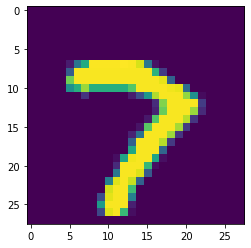

In [18]:
import matplotlib.pyplot as plt 

# tesing the NN

# show the image from the dataset
# this is specifically pulling the 3rd item, which is a 7
plt.imshow(X[3].view(28,28))
plt.show

In [19]:
# get the model prediction for the item in the dataset
print(torch.argmax(net(X[3].view(-1, 784))[0]))

# prediction is in the tensor()

tensor(7)


**^ Model guessed 7, which is correct**

## Moving Forward

**This is cool and all but:**

- we kinda cheated
- used our own dataset
- everything was pretty much done for us
- like balance issues
- normalization issues
- images were already grayscaled and scaled on 0-1
>
- now we're going to use a different dataset
- won't be our dataset, but will be raw images
- will be building a new, convolutional model 
>
- LOTS MORE TO LEARN